In [2]:
import os
import sys
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

repo_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(repo_root)

from src.utils.file_handlers import read_file_parameters


In [3]:
def convergence_file_handlers():
    data_path = os.path.join(os.getcwd(), 'data')

    all_results = []
    for file in os.listdir(data_path):
        if file.endswith('.csv'):
            result = read_file_parameters(file)
            result['avg_HO_iteration'] = 10000
            result['avg_PL_iteration'] = 10000

            file_path = os.path.join(data_path, file)
            df = pd.read_csv(file_path)
            #first iteration error is 0 
            df = df.iloc[1:]

            row_ho = df[df['Avg_HO_Error'] < 1e-10].head(1)
            if not row_ho.empty:
                result['avg_HO_iteration'] = row_ho['Iteration'].values[0]
            
            # Find the first row where Avg_PL_Error is below the threshold
            row_pl = df[df['Avg_PL_Error'] < 1e-10].head(1)
            if not row_pl.empty:
                result['avg_PL_iteration'] = row_pl['Iteration'].values[0]


            all_results.append(result)


    df = pd.DataFrame(all_results)
    numeric_columns = ['avg_HO_iteration', 'avg_PL_iteration']
    final_df = df.groupby('dataset')[numeric_columns].mean().reset_index()
    final_df['dataset'] = pd.to_numeric(final_df['dataset'], errors='coerce')
    return final_df.sort_values(by='dataset')


def visualize_df(df, title):
    print(f"\n{title}\n")
    styled_df = df.style.set_table_styles(
    ).set_properties(**{
        'background-color': 'LightGray',
        'color': 'black',
        'border-color': 'black',
        'border-style': 'solid',
        'border-width': '1px',
        'text-align': 'left'
    })
    styled_df = styled_df.format(precision=4)

    # print(df.to_latex(escape=True))
    display(styled_df)


In [4]:

df = convergence_file_handlers()
df.to_csv('results/convergence_table.csv')

In [5]:
title = "Convergence Results of Plackett-Luce and generalized BT"
visualize_df(df, title)


Convergence Results of Plackett-Luce and generalized BT



,dataset,avg_HO_iteration,avg_PL_iteration
0,1,10000.0000,10000.0000
8,2,779.7600,1520.1600
17,4,157.8800,372.1600
22,6,655.4000,1287.0400
23,7,14.5200,31.0000
24,8,10000.0000,10000.0000
25,9,12.0800,903.0000
5,12,12.7600,24.1200
6,14,33.6400,52.6000
7,18,4078.6400,9893.5600


In [11]:
def visualize_dataset_convergence(dataset_id):
    directory = os.path.join(os.getcwd(), 'data')
    reps = 0

    avg_HO_error = np.zeros(10000)
    avg_Pl_error = np.zeros(10000)

    for filename in os.listdir(directory):
        if filename.startswith(f'dataset-{dataset_id}_'):

            reps +=1
            # Construct the full file path
            file_path = os.path.join(directory, filename)
            # Load data into a pandas DataFrame
            df = pd.read_csv(file_path)

            HO_error = np.array(df['Avg_HO_Error'])
            PL_error = np.array(df['Avg_PL_Error'])

            avg_HO_error += HO_error
            avg_Pl_error += PL_error


    avg_HO_error = avg_HO_error[:10000]/reps
    avg_PL_error = avg_Pl_error[:10000]/reps
    above_thresh_ho = stop_array_sequentially(avg_HO_error[1:])
    above_thresh_PL = stop_array_sequentially(avg_PL_error[1:])

    return above_thresh_ho, above_thresh_PL


def stop_array_sequentially(array, threshold=1e-6):
    for i, value in enumerate(array):
        if value < threshold:
            print(array[i])
            return array[:i]
    return array


def plot_convergence(above_thresh_ho, above_thresh_PL):
    plt.figure(figsize=(12, 10))
    plt.plot(above_thresh_ho, label='HO')
    plt.plot(above_thresh_PL, label='Plackett-Luce')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Average Error')
    plt.legend()

    plt.savefig('Convergence')
    plt.show()


9.769701733830516e-07


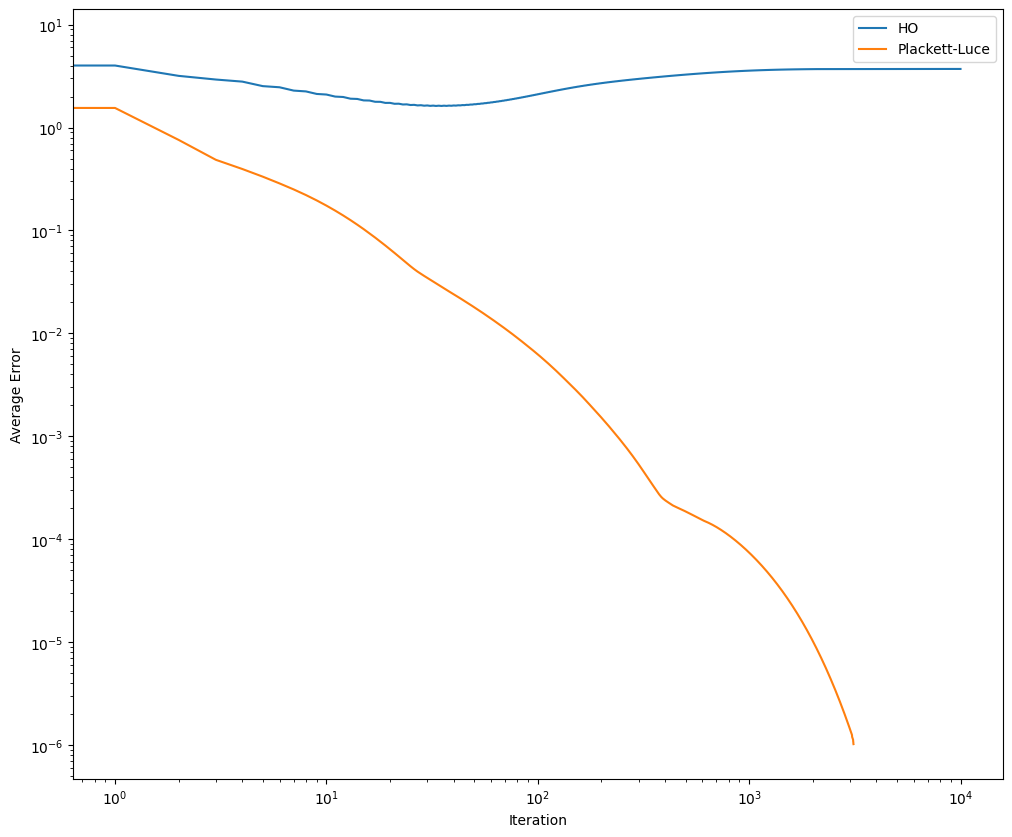

In [16]:
above_thresh_ho, above_thresh_PL = visualize_dataset_convergence(42)
plot_convergence(above_thresh_ho,above_thresh_PL)